In [60]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot as plt

In [134]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
C_LambdaList = [0.01,0.03,0.5,1,1.5,3]
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [83]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

#Generating the raw data structure
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    #removing the cloumns 5,6,7,8,9 as they have 0 values in the entire dataset ",
    #thus having 0 covariance ,hence these features wont affect the outcome,hence removed .Moreover it will be",
    #0 in the covariance matrix ,hence it won't be invertible
    
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    #41 (features) * 69K dataMatrix generated
    return dataMatrix

#generating training target dataset
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    #55K * 1 training target dataset generated
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    
    #Generated Training data Matrix with dimension 41 * 55K
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    
    #Generated the validation and testing dataset with dimension  41 * 6962
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    
    #Generated validation and target vector with dimension 6962 * 1
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    #creating one 41 *41 matrix as we have 41 features.Data is a 41*65k matrix\
    
    BigSigma    = np.zeros((len(Data),len(Data)))
    #transposing data to 65K *41
    DataT       = np.transpose(Data)
    #Training length is 80% of 65k which is 55k
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    
    #print(Data.shape)\n",
    #print(DataT.shape)\n",
    #print(DataT[0])\n",
    #print(TrainingLen)
    
    #loop is from 0 to 41
    for i in range(0,len(DataT[0])):
        vct = []
        #Training length is 55k (80% of dataset)
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j]) 
        #calculating the variance for each  feature across 55k dataset values and storing it in varvact vector
        #varvect has a dimension of 41 * 1
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        #storing the value of varvect vector in a diagnol matrix BigSigma with dimension 41 * 41
        
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma) #No effect on Erms even on changing the value to 2000
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow) #(x-mu)
    T = np.dot(BigSigInv,np.transpose(R))  #big sigma inverse * (x-mu)transpose
    L = np.dot(R,T)#(x-mu) * big sigma inverse * (x-mu)transpose
    
    #(x-mu) dimension is 1 * 41",
    #Big sigma inverse dimension is 1 * 41",
    #(x-mu) transpose dimension is 41 * 4",
    #This gives a scalar value which is stored in the design matrix or the phi matrix
    
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    #Calculating -0.5(x-mu)* big sigma inverse * (x-mu)transpose
    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))   #55K * 10 for training dataset      
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma) #inverting the bigSigma matrix
    for  C in range(0,len(MuMatrix)): # 0 to 10
        for R in range(0,int(TrainingLen)): # 0 to 55K
            #Getting the output generated by the gaussian function and storing it in the phi matrix or design matrix
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
    #This is also called  Moore-Penrose pseudo-inverse of the matrix Φ 
    #where W= (λI + Φ_transpose * Φ)_inverse * Φ_transpose * (targer vaector)
    #Creating the Lambda regularizer where Lambda is multiplied with an identity matrix
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI) #phi_transpose 
    PHI_SQR     = np.dot(PHI_T,PHI) #phi_transpose * phi
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR) #LambdaI + phi_transpose * phi
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)#Inverse of (λI + Φ_transpose * Φ)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)#Inverse of (λI + Φ_transpose * Φ) * Φ_transpose 
    W           = np.dot(INTER, T) #Inverse of (λI + Φ_transpose * Φ) * Φ_transpose * target_vector(T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))  #55K * 10 for training dataset  
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma) #inverting the bigSigma matrix
    for  C in range(0,len(MuMatrix)): # 0 to 10
        for R in range(0,int(TrainingLen)): # 0 to 55K
            #Getting the output generated by the gaussian function and storing it in the phi matrix or design matrix
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    #print(VAL_PHI.shape)
    #print(W.shape)
    Y = np.dot(W,np.transpose(VAL_PHI)) #Φ_transpose * W which gives the predicted target values
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        #sum = sum + (ValDataAct[i] - VAL_TEST_OUT[i])**2
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    
    #Calculating the Erms which is sqrt of square of difference of true values and predicted values divide by
    # number of datasets
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [29]:
#Generating target array data structure where 0 represent least releveant and 2 most relevant

RawTarget = GetTargetVector('Querylevelnorm_t.csv')
#Generating raw datastructure
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 'U' mode is deprecated
  del sys.path[0]


## Prepare Training Data

In [30]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [31]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [32]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [33]:
#This code tests the change in  Erms for closed form solution with change in number of basis functions
M_List = [1,5,10,15,20,25,30,35]
TRAINING_PHI_LIST=[]
TEST_PHI_LIST=[]
VAL_PHI_LIST=[]
W_LIST=[]
for M in M_List:
    
    ErmsArr = []
    AccuracyArr = []

#Clustering the dataset into 10 clusters ",
#n_clusters is the number of clusters which becomes the number of basis functions",
#ransdom state 0 means the random number for the centroid initialization",
#Mu vector contains the centroid values for all the 10 clusters for all the 41 features",
#kmeans.cluster_centers_ returns the mu marix 10*41 having the mean(centroid) per cluster for all 41 features",
#print(Mu)",
#print(Mu.shape)"


    kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_
#Generating the Big sigma matrix which is common for the entire dataset and is used in val_phi and test_phi
    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
#Generation the design or phi matrix for training data
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    TRAINING_PHI_LIST.append(TRAINING_PHI)

#Calculationg the weights,here C_Lambda is used as a regularizer to prevent overfitting of the model
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda))
    W_LIST.append(W)

#Generation the design or phi matrix for testing data
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100)
    TEST_PHI_LIST.append(TEST_PHI)

#Generation the design or phi matrix for validation data
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
    VAL_PHI_LIST.append(VAL_PHI)

In [135]:
#This code tests the change in  Erms for closed form solution with change in Lambda or the regularizer

ErmsArr = []
AccuracyArr = []
W_LIST_LAMBDA=[]
#Clustering the dataset into 10 clusters ",
#n_clusters is the number of clusters which becomes the number of basis functions",
#ransdom state 0 means the random number for the centroid initialization",
#Mu vector contains the centroid values for all the 10 clusters for all the 41 features",
#kmeans.cluster_centers_ returns the mu marix 10*41 having the mean(centroid) per cluster for all 41 features",
#print(Mu)",
#print(Mu.shape)"


kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_
#Generating the Big sigma matrix which is common for the entire dataset and is used in val_phi and test_phi
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
#Generation the design or phi matrix for training data
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)

#Calculationg the weights,here C_Lambda is used as a regularizer to prevent overfitting of the model
for C in C_LambdaList:
    
    W = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C)) 
    W_LIST_LAMBDA.append(W)

#Generation the design or phi matrix for testing data
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 

#Generation the design or phi matrix for validation data
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [34]:
#print(Mu.shape)
#print(BigSigma.shape)
#print(TRAINING_PHI.shape)
#print(W.shape)
#print(VAL_PHI.shape)
#print(TEST_PHI.shape)

## Finding Erms on training, validation and test set 

[0.6278937255835154, 0.6279788453856765, 0.6282321603005984, 0.6282247341563227, 0.6282104241531032, 0.6281973044337429]
[0.01, 0.03, 0.5, 1, 1.5, 3]


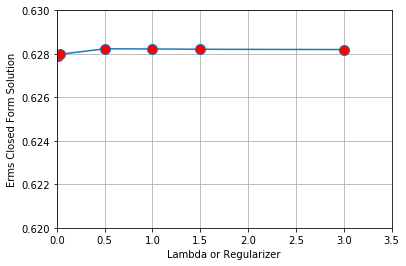

In [139]:
ErmsLambdaList=[]
for W in W_LIST_LAMBDA:
    
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)
    ErmsLambdaList.append(float(GetErms(TEST_OUT,TestDataAct).split(',')[1]))

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    #TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
#print(ErmsLambdaList)
#print(C_LambdaList)
generateErmsGraph(ErmsLambdaList,C_LambdaList,0,3.5,0.62,0.63)    

UBITname = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
[0.6402356289634681, 0.6311320276632603, 0.6279788453856765, 0.6273341085294319, 0.6261902077808426, 0.6241635963123179, 0.6229631910813109, 0.6210969595210213]


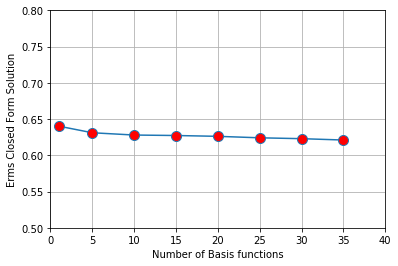

In [70]:
TrainingErms_List=[]
ValidationErms_List=[]
TestErms_List=[]
for i in range(0,len(M_List)):
    
    TR_TEST_OUT  = GetValTest(TRAINING_PHI_LIST[i],W_LIST[i])
    VAL_TEST_OUT = GetValTest(VAL_PHI_LIST[i],W_LIST[i])
    TEST_OUT     = GetValTest(TEST_PHI_LIST[i],W_LIST[i])
    x=GetErms(TR_TEST_OUT,TrainingTarget)
    TrainingErms_List.append(x.split(',')[1])
    y=GetErms(VAL_TEST_OUT,ValDataAct)
    ValidationErms_List.append(y.split(',')[1])
    z=GetErms(TEST_OUT,TestDataAct)
    #print(float(z.split(',')[1]))
    TestErms_List.append(float(z.split(',')[1]))
    #print(TestErms_List)

    #TrainingAccuracy   = str(x)
    #ValidationAccuracy = str(y)
    #TestAccuracy       = str(z)

    
print ('UBITname = APURBAMA') 
print ('Person Number = 50288705') 
print ('----------------------------------------------------') 
print ("------------------LeToR Data------------------------") 
print ('----------------------------------------------------') 
print ("-------Closed Form with Radial Basis Function-------") 
print ('----------------------------------------------------')

#for j in range(0,len(M_List)):

#print ("M = "+str(M_List[j])+"\nLambda = 0.03")
#print(ValidationErms_List[j])
#print ("E_rms Training   = " + str(TrainingErms_List[j]))
#print ("E_rms Validation = " + str(ValidationErms_List[j]))
#print ("E_rms Testing    = " + str(TestErms_List[j]))
generateErmsGraph(TestErms_List,M_List,0,40,0.5,0.8)    

print ('UBITname      = APURBAMA')
print ('Person Number = 50288705')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')

#for j in range(0,len(M_List)):
    
    #print ("M = "+str(M_List[j])+"\nLambda = 0.03")
    #print(ValidationErms_List[j])
    #print ("E_rms Training   = " + str(TrainingErms_List[j]))
    #print ("E_rms Validation = " + str(ValidationErms_List[j]))
    #print ("E_rms Testing    = " + str(TestErms_List[j]))

generateErmsGraph(TestErms_List,M_List)    

## Gradient Descent solution for Linear Regression

In [41]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 10 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [101]:
#W_Now        = np.dot(220, W) # randomizing the weights to multiplying with a random scalr value
La           = 2 #Regularizer to remove overfitting of the model. It is multiplied to the weights
learningRate = 0.01 #Learning rate in the gradient descent solution which is multiplied with delat_E,which 
#decides how big an update is made to the weights
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
Erms_TR_List = []
Erms_Val_List = []
Erms_Test_List = []

#Running for 400 iterations only as the Erms for the model does not improve after that value

learningRateList = [0.01,0.05,0.1,0.15,0.2,0.3,0.001] #Testing the effect of increase in learning rate in Erms of Gradient Descent
#Taking M(number of basis function as 10)
for z in range(0,1):
    TRAINING_PHI=TRAINING_PHI_LIST[2]
    W_Now        = np.dot(220, W_LIST[2])
    VAL_PHI=VAL_PHI_LIST[2]
    TEST_PHI=TEST_PHI_LIST[2]
    
    for i in range(0,400):
        
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    #  According to Gradient descent solution Delta_E_D is given by -(True values - weights_transpose * phi)*phi
    # ∇ED = −(tn − w_transpose * φ(xn)) * φ(xn)
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    
    #La is a regularizer which is multiplied with the weights
        La_Delta_E_W  = np.dot(La,W_Now)
    
    # ∇E= ∇ED + λ∇EW
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)  
    # ∇W= -learning_rate * Delta_E(∇E)
        #Delta_W       = -np.dot(learningRate,Delta_E)
        Delta_W       = -np.dot(learningRateList[1],Delta_E)
    
    #Weights_updated = Weights + (-learning_rate * Delta_E)
        W_T_Next      = W_Now + Delta_W
    #W_T_Next is now the updated weights
        W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) #Generating test data predicted output
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget) #calculating the Erms for the current iteration
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))# storing all the Erms values and later printing out the min Erms
    
    #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) #Generating validation data predicted output
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)#calculating the validation Erms for the current iteration
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))# storing all the Erms values and later printing out the min Erms
    
    #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) #Generating test data predicted output
        Erms_Test = GetErms(TEST_OUT,TestDataAct) #calculating the test Erms for the current iteration
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))# storing all the Erms values and later printing out the min Erms
        
    Erms_TR_List.append(np.around(min(L_Erms_TR),5))
    Erms_Val_List.append(np.around(min(L_Erms_Val),5))
    Erms_Test_List.append(np.around(min(L_Erms_Test),5))

In [141]:
#This part of the code is to test the change in regularizer in Erms for the gradient descent solution
W_Now        = np.dot(220, W) # randomizing the weights to multiplying with a random scalr value
La           = 2 #Regularizer to remove overfitting of the model. It is multiplied to the weights
learningRate = 0.01 #Learning rate in the gradient descent solution which is multiplied with delat_E,which 
#decides how big an update is made to the weights
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
LaList=[2,4,6,8,12]
ErmsListLA=[]
#Running for 400 iterations only as the Erms for the model does not improve after that value
for L in LaList:
    for i in range(0,400):
        
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    #  According to Gradient descent solution Delta_E_D is given by -(True values - weights_transpose * phi)*phi
    # ∇ED = −(tn − w_transpose * φ(xn)) * φ(xn)
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    
    #La is a regularizer which is multiplied with the weights
        La_Delta_E_W  = np.dot(L,W_Now)
    
    # ∇E= ∇ED + λ∇EW
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)  
    # ∇W= -learning_rate * Delta_E(∇E)
        Delta_W       = -np.dot(learningRate,Delta_E)
    
    #Weights_updated = Weights + (-learning_rate * Delta_E)
        W_T_Next      = W_Now + Delta_W
    #W_T_Next is now the updated weights
        W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) #Generating test data predicted output
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget) #calculating the Erms for the current iteration
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))# storing all the Erms values and later printing out the min Erms
    
    #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) #Generating validation data predicted output
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)#calculating the validation Erms for the current iteration
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))# storing all the Erms values and later printing out the min Erms
    
    #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) #Generating test data predicted output
        Erms_Test = GetErms(TEST_OUT,TestDataAct) #calculating the test Erms for the current iteration
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))# storing all the Erms values and later printing out the min Erms
    
    ErmsListLA.append(min(L_Erms_Test))
    print(ErmsListLA)
    

[0.6242334171143571]
[0.6242334171143571, 0.6242334171143571]
[0.6242334171143571, 0.6242334171143571, 0.6242334171143571]
[0.6242334171143571, 0.6242334171143571, 0.6242334171143571, 0.6242334171143571]
[0.6242334171143571, 0.6242334171143571, 0.6242334171143571, 0.6242334171143571, 0.6242334171143571]


[0.6242334171143571, 0.6242334171143571, 0.6242334171143571, 0.6242334171143571, 0.6242334171143571]
[2, 4, 6, 8, 12]


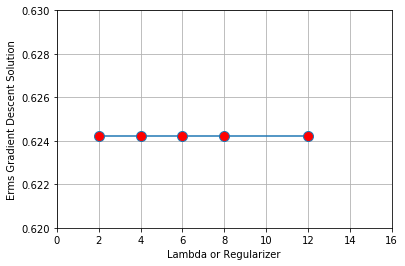

In [146]:
generateErmsGraph(ErmsListLA,LaList,0,16,0.62,0.63)

----------Gradient Descent Solution--------------------
E_rms Testing    = 0.62384


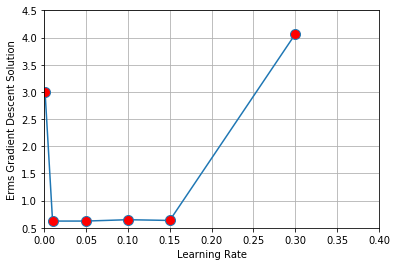

In [106]:
print ('----------Gradient Descent Solution--------------------')
#for i in range(0,len(M_List)):
    
    #print ("M = "+str(M_List[i])+" \nLambda  = 2\neta=0.01")
# Model ouput is least Erms for all training ,validation and test
    #print ("E_rms Training   = " + str(Erms_TR_List[i])) # Model ouput is least Erms
    #print ("E_rms Validation = " + str(Erms_Val_List[i]))
print ("E_rms Testing    = " + str(Erms_Test_List[0]))

generateErmsGraph([3.0067,0.62372,0.62384,0.6489,0.6353,4.06435],[0.001,0.01,0.05,0.1,0.15,0.3],0,0.4,0.5,4.5)    

In [145]:
def generateErmsGraph(ErmsList,M_List,xlow,xup,ylow,yup):
    plt.axis([xlow, xup, ylow, yup])
    plt.ylabel('Erms Gradient Descent Solution')
    plt.xlabel('Lambda or Regularizer')
    plt.grid(True)
    print(ErmsList)
    print(M_List)
    plt.plot(M_List,ErmsList, '-o', markersize = 10, markerfacecolor = 'r')
    plt.show()